Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import plotly.express as px

In [2]:
path1 = '/home/jupyter-a.jakovleva-13/final_project/Проект_4_active_users.csv'
path2 = '/home/jupyter-a.jakovleva-13/final_project/Проект_4_groups.csv'
path3 = '/home/jupyter-a.jakovleva-13/final_project/Проект_4_purchases.csv'
active_users = pd.read_csv(path1) #информация о пользователях, которые посещали приложение во время эксперимента.
groups       = pd.read_csv(path2) #разбивка пользователей на контрольную (А) и тестовую (В) группы. 
purchases    = pd.read_csv(path3) #данные о транзакциях (оплатах) пользователей приложения во время эксперимента 

In [3]:
# изучение данных
active_users.dtypes
groups.dtypes
purchases.dtypes

#проверка уникальности user_id
active_users.user_id.nunique() == active_users.shape[0]
purchases.user_id.nunique() == purchases.shape[0] 
groups.user_id.nunique() == groups.shape[0]

print(active_users.shape[0], groups.shape[0], purchases.shape[0])

8341 74576 541


In [4]:
groups.group.value_counts() # количество польз-лей в тестовой группе в 4 раза больше, чем в контрольной.

B    59883
A    14693
Name: group, dtype: int64

In [5]:
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [6]:
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [7]:
purchases['purchase'] = 1
purchases.head()

,user_id,revenue,purchase
0,4412,1000.0,1
1,9000,701.0,1
2,9001,700.0,1
3,9002,702.0,1
4,5790,1002.0,1


In [8]:
purchases.user_id.value_counts()
purchases.user_id.nunique() == purchases.shape[0] #проверка уникальности user_id

True

In [9]:
all_users = groups.merge(purchases,  how='left',on='user_id').merge(active_users,  how='left',on='user_id')

In [10]:
users_isna = all_users.isna().query('revenue == False and sex == True').shape[0]

In [11]:
# удаление пропущенных значений
users = all_users.dropna(how='all', subset=['revenue', 'sex'])
users

,user_id,group,revenue,purchase,country,platform,sex
60,9061,B,699.0,1.0,NaN,NaN,NaN
372,1488,B,NaN,NaN,Russia,android,male
593,9036,B,300.0,1.0,NaN,NaN,NaN
594,9073,B,702.0,1.0,NaN,NaN,NaN
649,5125,B,NaN,NaN,Russia,ios,female
...,...,...,...,...,...,...,...
74571,1010,B,NaN,NaN,Sweden,android,male
74572,7785,A,NaN,NaN,Sweden,android,male
74573,1783,B,NaN,NaN,Russia,ios,female
74574,1164,A,NaN,NaN,Sweden,android,male


In [12]:
# проверка merge == True, 2, 8490
print(users.revenue.sum() == purchases.revenue.sum())
print(users.shape[0] == (users_isna + active_users.shape[0]))
print(users.group.nunique())
print(users.user_id.nunique())

True
True
2
8490


In [13]:
users = users.fillna(0)

## Формирование метрик, анализ

In [15]:
# называем переменные

revenue_sum_A = users[users.group == 'A'].revenue.sum()     # общий доход
revenue_sum_B = users[users.group == 'B'].revenue.sum()

purchase_sum_A = users[users.group == 'A'].purchase.sum()   # сумма покупок
purchase_sum_B = users[users.group == 'B'].purchase.sum()

all_users_A = users.query('group == "A"').shape[0]          # кол-во польз-лей за период эксперимента
all_users_B = users.query('group == "B"').shape[0]

Метрики по группам

In [16]:
# выручка 

revenue_sum_A
revenue_sum_B

# конверсия в покупку
CR_A = purchase_sum_A / all_users_A
CR_B = purchase_sum_B / all_users_B

# средний чек
avg_A = revenue_sum_A / purchase_sum_A
avg_B = revenue_sum_B / purchase_sum_B

# коэффициент повторных покупок == 1 (так как изначально считаем, что пользователь совершает только 1 покупку)
repeat_purchases_A = 1
repeat_purchases_B = 1

# ARPPU 
ARPPU_A = repeat_purchases_A * avg_A
ARPPU_B = repeat_purchases_B * avg_B

# ARPU 
ARPU_A = revenue_sum_A / all_users_A
ARPU_B = revenue_sum_B / all_users_B

In [17]:
metrics = pd.DataFrame({
                        'group': ['A', 'B'],
                        'revenue': [revenue_sum_A, revenue_sum_B],
                        'CR': [CR_A, CR_B],
                        'avg': [avg_A, avg_B],
                        'ARPPU': [ARPPU_A, ARPPU_B],
                        'ARPU': [ARPU_A, ARPU_B]
                       })


metrics.round(2)

,group,revenue,CR,avg,ARPPU,ARPU
0,A,93162.0,0.07,870.67,870.67,59.45
1,B,485575.0,0.06,1118.84,1118.84,70.14


In [24]:
# формируем табличку с расчетом метрик в разрезе страны, пола и платформы
avg_users_A = users.query('purchase == 1 and group == "A"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'revenue':'mean'})
avg_users_B = users.query('purchase == 1 and group == "B"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'revenue':'mean'})
count_users_A = users.query('group == "A"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'revenue':'count'})
count_users_B = users.query('group == "B"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'revenue':'count'})
count_purchase_users_A = users.query('purchase == 1 and group == "A"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'purchase':'count'})
count_purchase_users_B = users.query('purchase == 1 and group == "B"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'purchase':'count'})


revenue_users_A = users.query('group == "A"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'revenue':'sum'})
revenue_users_B = users.query('group == "B"').groupby(['group', 'country', 'platform', 'sex'], as_index=False)\
                .agg({'revenue':'sum'})

revenue_users_A['avg_A'] = avg_users_A.revenue
revenue_users_B['avg_B'] = avg_users_B.revenue

revenue_users_A['user_count_A'] = count_users_A.revenue
revenue_users_B['user_count_B'] = count_users_B.revenue

revenue_users_A['purchase_A'] = count_purchase_users_A.purchase
revenue_users_B['purchase_B'] = count_purchase_users_B.purchase

revenue_users_A['arpu_A'] = revenue_users_A.revenue / revenue_users_A.user_count_A
revenue_users_B['arpu_B'] = revenue_users_B.revenue / revenue_users_B.user_count_B

revenue_users_A['CR_A'] = revenue_users_A.purchase_A / revenue_users_A.user_count_A
revenue_users_B['CR_B'] = revenue_users_B.purchase_B / revenue_users_B.user_count_B

revenue_users_A = revenue_users_A.rename(columns={'revenue': 'revenue_A'})
revenue_users_B = revenue_users_B.rename(columns={'revenue': 'revenue_B','country': 'country_B', 'platform': 'platform_B', 'sex': 'sex_B'})

metrics_users = pd.concat([revenue_users_A, revenue_users_B], axis=1)[['country', 'platform', 'sex', 'revenue_A', 'revenue_B','avg_A', 'avg_B','purchase_A', 'purchase_B','arpu_A', 'arpu_B','CR_A', 'CR_B',]]
metrics_users['diff_revenue'] = metrics_users.revenue_B - metrics_users.revenue_A
metrics_users['diff_avg'] = metrics_users.avg_B - metrics_users.avg_A
metrics_users['diff_arpu'] = metrics_users.arpu_B - metrics_users.arpu_A
metrics_users['diff_CR'] = metrics_users.CR_B - metrics_users.CR_A
metrics_users = metrics_users.round(2)
metrics_users

,country,platform,sex,revenue_A,revenue_B,avg_A,avg_B,purchase_A,purchase_B,arpu_A,arpu_B,CR_A,CR_B,diff_revenue,diff_avg,diff_arpu,diff_CR
0,0,0,0,19564.0,87462.0,674.62,728.85,29,120,674.62,728.85,1.00,1.00,67898.0,54.23,54.23,0.00
1,Russia,android,female,9280.0,66263.0,843.64,1352.31,11,49,34.76,54.76,0.04,0.04,56983.0,508.67,20.01,-0.00
2,Russia,android,male,4382.0,65143.0,547.75,1206.35,8,54,18.03,51.37,0.03,0.04,60761.0,658.60,33.34,0.01
3,Russia,ios,female,11608.0,59630.0,892.92,1325.11,13,45,66.71,58.86,0.07,0.04,48022.0,432.19,-7.85,-0.03
4,Russia,ios,male,10137.0,48406.0,921.55,987.88,11,49,43.88,48.36,0.05,0.05,38269.0,66.33,4.47,0.00
5,Sweden,android,female,4145.0,37926.0,690.83,1149.27,6,33,25.59,57.29,0.04,0.05,33781.0,458.44,31.70,0.01
6,Sweden,android,male,22091.0,38950.0,1577.93,1180.30,14,33,136.36,60.20,0.09,0.05,16859.0,-397.63,-76.16,-0.04
7,Sweden,ios,female,6674.0,47195.0,953.43,1747.96,7,27,44.49,93.09,0.05,0.05,40521.0,794.53,48.59,0.01
8,Sweden,ios,male,5281.0,34600.0,660.12,1441.67,8,24,35.44,69.90,0.05,0.05,29319.0,781.54,34.46,-0.01


In [33]:
metrics_users[['country','diff_revenue', 'sex', 'diff_revenue', 'diff_avg', 'diff_arpu', 'diff_CR']]

,country,diff_revenue,sex,diff_revenue,diff_avg,diff_arpu,diff_CR
0,0,67898.0,0,67898.0,54.23,54.23,0.00
1,Russia,56983.0,female,56983.0,508.67,20.01,-0.00
2,Russia,60761.0,male,60761.0,658.60,33.34,0.01
3,Russia,48022.0,female,48022.0,432.19,-7.85,-0.03
4,Russia,38269.0,male,38269.0,66.33,4.47,0.00
5,Sweden,33781.0,female,33781.0,458.44,31.70,0.01
6,Sweden,16859.0,male,16859.0,-397.63,-76.16,-0.04
7,Sweden,40521.0,female,40521.0,794.53,48.59,0.01
8,Sweden,29319.0,male,29319.0,781.54,34.46,-0.01


наибольшая разница наблюдается в показателях у польз-лей Швеции на IOS и у польз-лей России на android

In [34]:
# добавляем колонку CR в датафрейм
CR_group_A = users.purchase / all_users_A
CR_group_B = users.purchase / all_users_B
users['CR'] = np.where(users.group == 'A', CR_group_A, CR_group_B)

In [35]:
# проверка расчетов == True
print(round(CR_A, 2) == round(users.query('group == "A"').CR.sum(), 2),
      round(CR_B, 2) == round(users.query('group == "B"').CR.sum(), 2))
print(round(ARPU_A, 2) == round(ARPPU_A * CR_A, 2),
      round(ARPU_B, 2) == round(ARPPU_B * CR_B, 2))

True True
True True


In [36]:
print(users[users.group == 'A'].revenue.max(),
      users[users.group == 'B'].revenue.max())
# максимальные значения отличаются не критично

3671.0 4660.0


В таблице metrics видна тенденция увеличения всех показателей, кроме конверсии в покупку.
По показателю выручки обнаружена наибольшая разница (в группе 'B' в 5 раз больше), 
однако при анализе исходных данных (groups) видно, 
что количество польз-лей в тестовой группе в 4 раза больше, чем в контрольной.

Предварительный вывод: пользователи из тестовой группы больше тратят денег на приложение.

## А/В тестирование по показателям: revenue, CR, ARPU

In [37]:
# для комментариев
def pvalue(p):
    if p <= 0.05/3:                                       # Поправка Бонферони
        print('Статистически значимые различия есть')
    else:
        print('Статистически значимых различий нет')
    return (p)

def shapiro_pvalue(p):
    if p <= 0.05/3:
        print('Рапределение отличается от нормального')
    else:
        print('Рапределение нормальное')
    return (p)

1. Revenue

In [38]:
#проверка нормальности распределения
from scipy.stats import shapiro
test_A = users[users.group == 'A'].revenue
test_B = users[users.group == 'B'].revenue
stat, p_A = stats.shapiro(test_A.sample(1000, random_state = 17))
stat, p_B = stats.shapiro(test_B.sample(1000, random_state = 17))

shapiro_pvalue(p_A)
shapiro_pvalue(p_B)

Рапределение отличается от нормального
Рапределение отличается от нормального


0.0

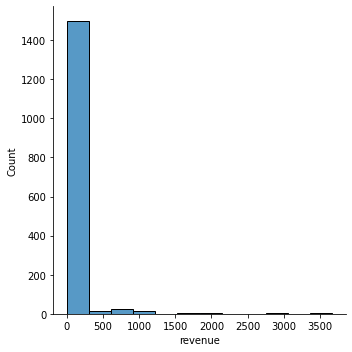

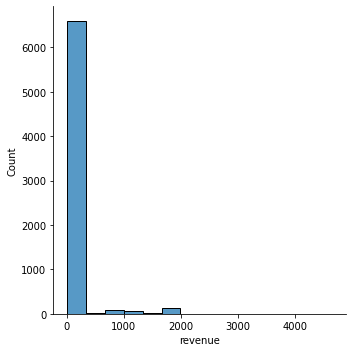

In [39]:
#визуализация распределения
sns.displot(test_A)
sns.displot(test_B)

In [40]:
# А/Б тест Revenue с помощью метода Манна-Уитни U
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(test_A, test_B)

pvalue(p)

Статистически значимых различий нет


0.5033868440268043

2. Конверсия в покупку (CR)

In [41]:
#проверка нормальности распределения

test_CR_A = users[users.group == 'A'].CR
test_CR_B = users[users.group == 'B'].CR
stat, p_A = stats.shapiro(test_CR_A.sample(1000, random_state = 17))
stat, p_B = stats.shapiro(test_CR_B.sample(1000, random_state = 17))

shapiro_pvalue(p_A)
shapiro_pvalue(p_B)

Рапределение отличается от нормального
Рапределение отличается от нормального


0.0

In [42]:
# А/Б тест CR с помощью метода Манна-Уитни U

stat, p = mannwhitneyu(test_CR_A, test_CR_B)

pvalue(p)

Статистически значимых различий нет


0.14860270726904024

 3. ARPU

In [43]:
# добавляем колонку ARPU в датафрейм
ARPU_group_A = users.revenue / all_users_A
ARPU_group_B = users.revenue / all_users_B
users['ARPU'] = np.where(users.group == 'A', ARPU_group_A, ARPU_group_B)

In [44]:
# проверка расчетов == True
print(round(users.query('group == "A"').ARPU.sum(),2) == round(ARPU_A,2),
      round(users.query('group == "B"').ARPU.sum(),2) == round(ARPU_B,2))

True True


In [45]:
#проверка нормальности распределения

test_ARPU_A = users[users.group == 'A'].ARPU
test_ARPU_B = users[users.group == 'B'].ARPU
stat, p_A = stats.shapiro(test_ARPU_A.sample(1000, random_state = 17))
stat, p_B = stats.shapiro(test_ARPU_B.sample(1000, random_state = 17))

shapiro_pvalue(p_A)
shapiro_pvalue(p_B)

Рапределение отличается от нормального
Рапределение отличается от нормального


0.0

In [46]:
# А/Б тест ARPU с помощью метода Манна-Уитни U
stat, p = mannwhitneyu(test_ARPU_A, test_ARPU_B)

pvalue(p)

Статистически значимых различий нет


0.20910382585315024

Поищем взаимосвязь между фактом покупки и полом/платформой/страной пользователя по группам c помощь метода хи-квадрат

In [47]:
purchase_chi2 = users[['group','country','purchase', 'platform', 'sex']].query('platform != 0')
purchase_chi2['purchase'] = np.where(purchase_chi2['purchase'] == 1, 'purchase', 'no_purchase')

from scipy.stats import chi2_contingency, chi2 
#взаимосвязь факта покупки с полом пользователя
stat1, p1, dof1, expected1 = chi2_contingency(pd.crosstab(purchase_chi2.query('group == "A"').purchase, purchase_chi2.query('group == "A"').sex))
stat2, p2, dof2, expected2 = chi2_contingency(pd.crosstab(purchase_chi2.query('group == "B"').purchase, purchase_chi2.query('group == "B"').sex))

#взаимосвязь факта покупки с платформой пользователя
stat3, p3, dof3, expected3 = chi2_contingency(pd.crosstab(purchase_chi2.query('group == "A"').purchase, purchase_chi2.query('group == "A"').platform))
stat4, p4, dof4, expected4 = chi2_contingency(pd.crosstab(purchase_chi2.query('group == "B"').purchase, purchase_chi2.query('group == "B"').platform))

#взаимосвязь факта покупки с страной пользователя
stat5, p5, dof5, expected5 = chi2_contingency(pd.crosstab(purchase_chi2.query('group == "A"').purchase, purchase_chi2.query('group == "A"').country))
stat6, p6, dof6, expected6 = chi2_contingency(pd.crosstab(purchase_chi2.query('group == "B"').purchase, purchase_chi2.query('group == "B"').country))

pvalue(p1)
pvalue(p2)
pvalue(p3)
pvalue(p4)
pvalue(p5)
pvalue(p6)

Статистически значимых различий нет
Статистически значимых различий нет
Статистически значимых различий нет
Статистически значимых различий нет
Статистически значимых различий нет
Статистически значимых различий нет


0.23025488232039207

# Выводы:
По результатам исследования мы не можем отлонить нулевую гипотезу и внедрить новую систему оплаты для всех пользователей.

По результатам анализа таблицы metrics_users стоит обратить внимание:
    - в Швеции с новой моделью оплаты стикеров показатели денежных метрик растут у всех пользователей, кроме мужчин на андроиде. 
    - в России наблюдает рост метрик для пользователей платформы андроид, в то время как у пользователей платформы ios наблюдается спад.
Возможно, стоит проверить данные группы пользователей на наличие багов в системе оплаты, или провести соц. опрос.
Если действительно, в нашей новой системе оплаты скрыты баги, то необходимо найти их, исправить и провести новый А/Б тест.